# Unsupervised Quantum Learning with Max-cut

This notebook is an example of unsupervised machine learning on a quantum computer. Both classical and quantum algorithms are used in classifying the iris dataset.

First, we'll warm up on the classical k-means clustering algorithm. Hopefully, this quick review will refresh you on unsupervised learning. Next, we go quantum. The data are mapped to a graph; the [max-cut problem](https://en.wikipedia.org/wiki/Maximum_cut) is mapped to an Ising Hamiltonian; and QAOA solves for the ground state. If you want more details for each step check out this [kaggle tutorial](https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris) on k-means, this [qiskit tutorial](https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb) on max-cut, or the paper [*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771) on going quantum. There are plenty of other resource out there, but these are the ones I've found useful.

As usual, we import packages and take a peak at the data we'll be playing with.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

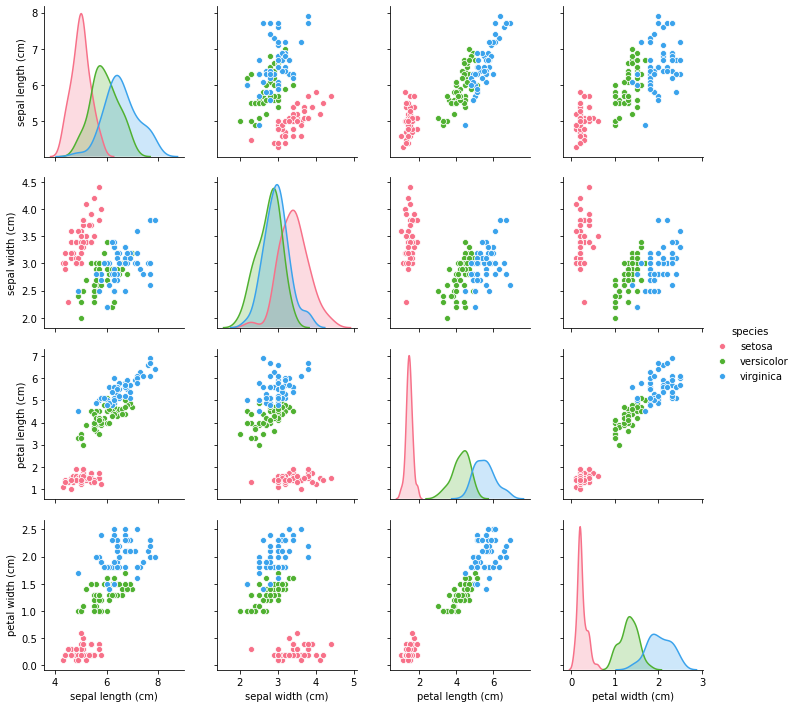

In [2]:
# Import Iris dataset
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names).astype(str)

# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=df, hue="species", palette="husl")
plt.show()

At a glance, it looks like there are ~100+ data points grouped into three species with versicolor and virginica much closer to each other.

Since the quantum computer will be simulated on laptops and not supercomputers, **let's reduce the dataset** to ~12 for a reasonable run time. Though the details haven't been explained yet, max-cut can only split data into two clusters. (More on that later.) For now, we'll need remove one of the species. To be nice to the quantum computer, let's remove virginica. If it can't cluster setosa and versicolor, we know quantum computers are really in trouble. If it can... well, maybe they really do have a shot at unsupervised learning.

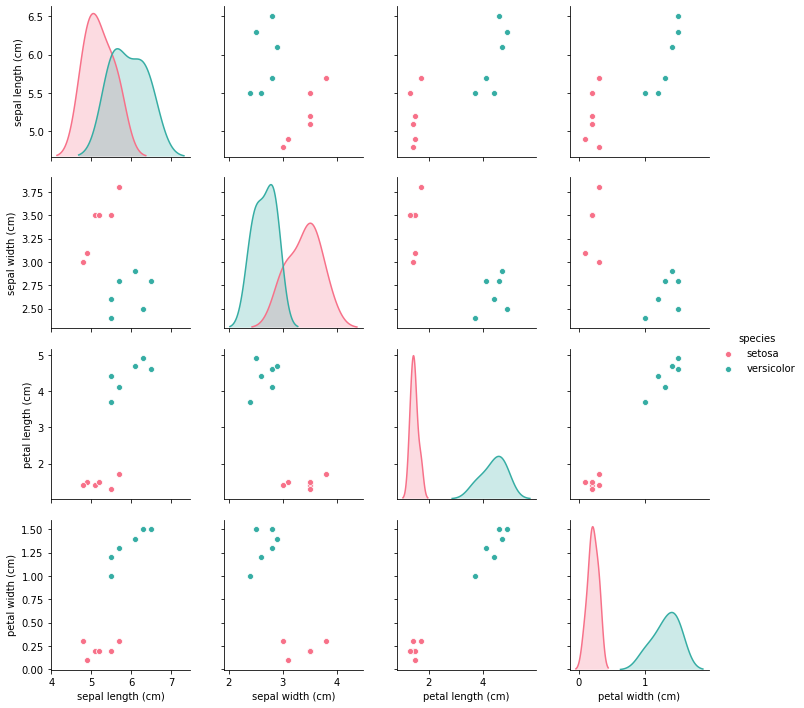

In [3]:
# Generate subset of data with fewer data points
df_sub = df.iloc[::9,:].reset_index(drop=True)

# Constrain data to 2 species
df_sub = df_sub.loc[(df_sub['species'] == 'setosa') | (df_sub['species'] == 'versicolor')]

# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=df_sub, hue="species", palette="husl")
plt.show()

Some dimensions of the feature space show the setosa and versicolor distributions quite close (e.g. sepal width vs. sepal length), while others have them separated (e.g. petal length vs. petal width). Those close features will make it harder to cluster, but with the more separated features, there's definitely room for accurate clustering. Let's see how k-means handles this.

## A Classical Approach
K-means groups data into k clusters by minimizing each cluster's sum-of-squares also known as inertia

$$
\sum_{i=0}^{n} \min_{\mu_j \in C}(\lvert\lvert x_i - \mu_j\rvert\rvert^2)
$$

where $\mu_j$ is the mean of the jth cluster within the set $C$ of clusters.
(See scikit-learn's [clustering user guide](https://scikit-learn.org/stable/modules/clustering.html#k-means) for more details.) The optimal number of clusters $k$ is known for this data ($k=2$) since the reduced dataset only contains two species. However, let's pretend that's unknown as that would be the case for a real unsupervised learning application. We can use the [elbow rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to find our "unknown" optimal $k$.

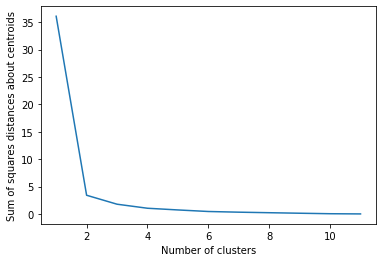

In [4]:
# Remove species labels (otherwise it's not unsupervised learning!)
df_sub_wo_labels = df_sub.loc[:,['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']]

# Elbow rule: compute inertia for difference k's
inertia = []
K = range(1, len(df_sub_wo_labels))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_sub_wo_labels)
    inertia.append(kmeans.inertia_)

# Visualize elbow rule
plt.plot(K, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares distances about centroids')
plt.show()

Two is obviously the most "elbowy" and thus the optimal $k$. Let's fit and visualize the k-means algorithm with the optimal $k = 2$.

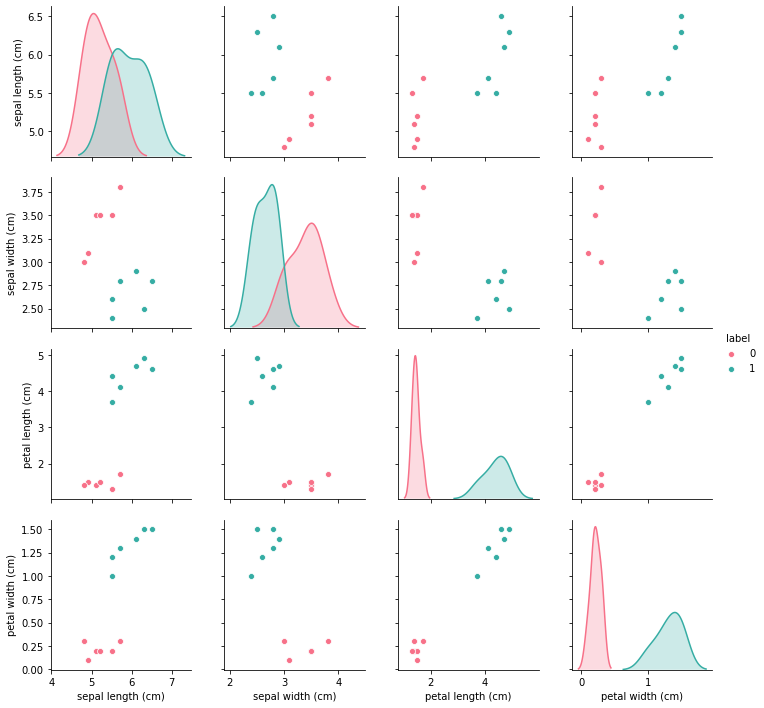

In [5]:
# Use optimal k for final k-means model
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(df_sub_wo_labels)

# Add k-means labeling to dataframe for later comparison
df_sub['label'] = kmeans.labels_

# Visualize clustering done by k-means algorithm
sns.pairplot(data=df_sub, hue='label', palette="husl", vars=df_sub.columns[:-2])
plt.show()

The plots looks identical to the reduced dataset plot! Yay! With $k = 2$, the k-means algorithm clustering did a fantastic job on the iris dataset! The elbow rule really pulled through. Let's see how the quantum computer fares.

## A Quantum Approach

One approach to unsupervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut in this notebook). The graph optimization problem can then be mapped to a cost Hamiltonian which can be efficiently solved by a quantum computer. (Cost Hamiltonians are the quantum computer version of cost functions.)

### Make a Graph

The first step is to map the data to a graph by calculating the pairwise "distances" between each data point. These distances will weight the edges of the graph. Let's use the $l^2\text{-norm}$ (i.e. vector magnitude). Remember, we're using a subset of the iris dataset to facilitate faster computation. 

In [6]:
# Get number of data entries
n_instances = len(df_sub_wo_labels)

# Convert dataframe into array
data_array = df_sub_wo_labels.values

# Calculate pairwise L2-norms (better performance for larger datasets can be acheived by using numba)
w = np.zeros((n_instances, n_instances))
for i in range(0, n_instances):
    for j in range(0, n_instances):
        w[i, j] = np.linalg.norm(data_array[i] - data_array[j])

print('Weight matrix size:', w.shape)

Weight matrix size: (12, 12)


### Cast Max-cut as a Cost Hamiltonian

To separate the graph into clusters, the graph is cut with a [max-cut](https://en.wikipedia.org/wiki/Maximum_cut): meaning the graph is separated in two while maximizing the total weight of the 'cut' edges. This is an NP-hard problem. However, it maps to an Ising model, which can be solved efficiently on a quantum computer! By efficiently, I mean it can solve the max-cut problem **FASTER** than a classical computer (theoretically speaking). **That is why this method is so interesting and important.** Though, it's been [proposed](https://www.nature.com/articles/s41598-019-43176-9) this won't actually be the case until there are quantum computers with hundreds of qubits.

Let's max-cut!

The cost of one cut between nodes $i$ and $j$ is the edge's weight $w_{ij}$ that lies between them. In separating the graph into two sets of nodes ($S_1$ for cluster 1 and $S_2$ for cluster 2), the total weight of a cut $\delta(S)$ is

$$
w(\delta(S)) = \sum_{i\in S_1, j\in S_2} w_{ij}.
$$

Assuming a fully connected graph and accounting for the symmetry of $w_{ij}$ (i.e. $w_{ij} = w_{ji}$), the sum can be expanded to
$$
\begin{align}
w(\delta(S)) & = \frac{1}{2}\sum_{(ij) \in \delta(S_1)} w_{ij} \\
& = \frac{1}{4}\sum_{ij} w_{ij} - \frac{1}{4} \sum_{ij} w_{ij} \hat{\sigma}_i^z \hat{\sigma}_j^z \\
& = \frac{1}{4}\sum_{ij} w_{ij} (1- \hat{\sigma}_i^z \hat{\sigma}_j^z).
\end{align}
$$                 

We can explicitly see it's connection to the Ising Hamiltonian (external field $h = 0$ and irrelevant constant $C$)

$$
H_{ising} = -\sum_{ij}J_{ij}\hat{\sigma}_i^z\hat{\sigma}_j^z + C
$$

where $J_{ij} = \frac{w_{ij}}{4}$. We interpret the output of the Ising model as follows. The spin variables $\hat{\sigma}_i^z \in \{-1, +1\}$ take on the value $\hat{\sigma}_i^z = +1$ for data in cluster 0, and $\hat{\sigma}_i^z = -1$ for data in cluster 1. To solve the optimization problem, the quantum computer finds the ground state of $H_{ising}$ and we're done! There are a variety of algorithms that can find the ground state of a cost Hamiltonian. In this notebook, we will use QAOA.

Side note: The Ising model is conventionally written as a sum over all **nearest neighbor** pairs $\sum_{<ij>}$. Since the graph is fully connected (or can be made fully connected by adding edges of weight zero), $\sum_{<ij>}$ is identical to the double sum $\sum_{ij}$.

The ideas and derivation presented here are directly found in the paper [*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771).

### Solve the Max-cut Problem with QAOA

[QAOA](https://arxiv.org/abs/1411.4028) is a quantum optimizer that will adiabatically find the ground state of a cost Hamiltonian--exactly what we need! Thankfully, [qiskit](https://qiskit.org) has a QAOA function all ready for us to use! Let's import the packages, initialize the QAOA algorithm with the weights $w$ we previously calculated and run it!!

In [7]:
# Packages needs to access an IBM quantum computer. Not necessary for simulator.
# from qiskit import IBMQ
# IBMQ.load_account()  # Load account from disk

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [8]:
# QAOA hyperparameters and initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()  # Classical optimizer
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)  # Compute qubit operations for QAOA algo
qaoa = QAOA(qubit_ops, optimizer, p)  # initialize QAOA algorithm

# Initialize quantum simulator
backend = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

# Initialize quantum computer
# provider = IBMQ.get_provider(group='open')  # Load provider to access IBM's cloud services
# backend = provider.get_backend('ibmq_essex')  # Compute on one of IBM's quantum computer

quantum_instance = QuantumInstance(backend, shots=1)

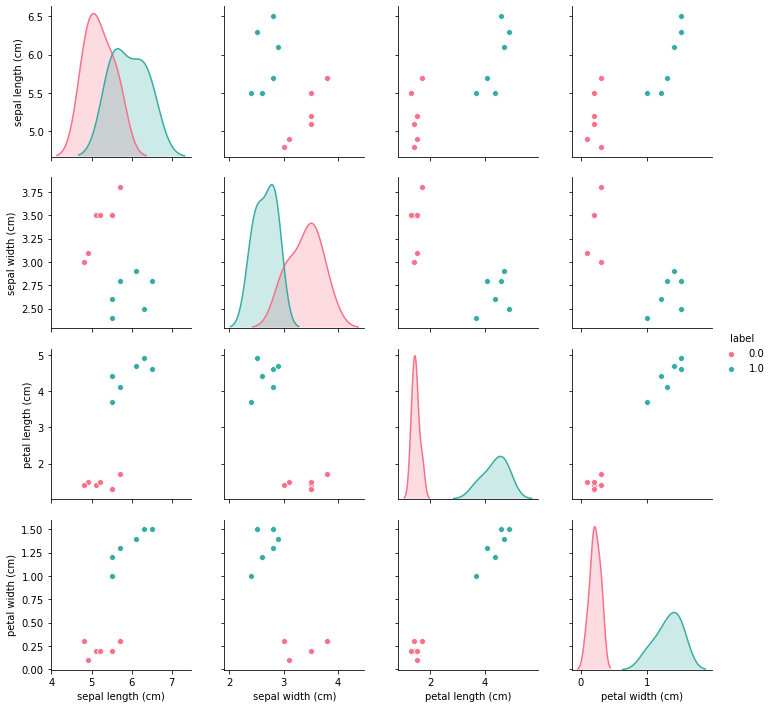

In [9]:
# Execute QAOA on quantum simulator (or real device)
result = qaoa.run(quantum_instance)

# Extract results
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Extract cluster labels and include them in df_sub
labels = pd.DataFrame(max_cut.get_graph_solution(x), columns=['label'])
df_sub['label'] = labels

# Show data by cluster
sns.pairplot(data=df_sub,hue='label', palette="husl", vars=df_sub.columns[:-2])
plt.show()

The plots look identical to the reduced dataset! All of setosa is in cluster 0, and all of versicolor is in cluster 1. For this simple example of solving max-cut with QAOA, the results look spectacular!

### Your turn
A great way to learn is to get your hands dirty. Mess around with this notebook and see what happens! Here are some questions to inspire your play:
* How do these results change when I execute on a real quantum computer?
* What happens if I filter out fewer data points?
* What happens if I include some data from the third species?
* What happens if I change the number of adiabatic steps (p) in the QAOA hyperparameters?
* What if I use VQE instead of QAOA to find the ground state of the cost Hamiltonian?

### Next time
**What about the third species?** We ignored it here because max-cut only classifies data into two clusters. Is there a way to use max-cut to give a 3 cluster classification? Or for that matter, any number of cluster classifications? That would make for a much more useful unsupervised learning algorithm. Hint: the answer is YES. Let's discuss it in the [next notebook](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut_2%2B_divisive_clustering.ipynb).